In [119]:
import datetime
####### START HERE ############
from data.coledb.coledb import ColeDBInterface
date = "2023-11-28"
end_time = "16:00:00"  # 4 pm
datetime_str = f"{date} {end_time}"
dt_object = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
formatted_date = dt_object.strftime('%y%b%d').upper()
close_time_unix = int(dt_object.timestamp())
filename = f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/bbo_INXZ_and_SPY_{date}.csv"
db = ColeDBInterface()
cole_db_path = db.cole_db_storage_path / f"INXZ/{formatted_date}"
market_suffix = list(cole_db_path.iterdir())[0].name
price_threshold = float(market_suffix[1:])*10

In [69]:
# Create file ONLY RUN THIS ONCE
assert False
from strategy.utils import get_spy_ob_bbo_merged_df
from helpers.types.markets import MarketTicker
date_no_hyphen = date.replace("-","")
df = get_spy_ob_bbo_merged_df(db, f"/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/databento/xnas-itch/spy/xnas-itch-{date_no_hyphen}.mbo.csv", MarketTicker(f"INXZ-{formatted_date}-{market_suffix}"))
df.to_csv(filename)

In [120]:

# Load data (instead of creating)
import pandas as pd

# LOAD DATA
df = pd.read_csv(filename)

# First remove any rows with nan spy (cleaned_df)
cdf = df[df['spy_price'].notna()]
cdf['spy_price'] /= 10000000
cdf = cdf[(cdf.ts >= close_time_unix - 23400) & (cdf.ts <= close_time_unix)]
cdf = cdf[((cdf.yes_bid_price).notna()) & ((cdf.yes_ask_price).notna())]
cdf['spy_diff_from_threshold'] = cdf['spy_price'] - price_threshold
cdf['spy_price_expanding_std_dev'] = cdf.spy_price.expanding().std()

/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1618/4085096316.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['spy_price'] /= 10000000


In [121]:
params = [0.08, -15.25e-07 , 0.035]

In [122]:
# New model with linear time change 
import numpy as np 
def time_multiplier(time):
    m = (0.01 - 0.025) / (24000 - 0)
    b = 0.01 - m * 24000
    print(float(m))
    print(b)
    return m * time + b
def sigmoid(x, multiplier):
    return (1 / (1 + np.exp(-1*x*multiplier)))
def get_cdf_with_params(cdf, x):
    shift_up = x[0]
    m = x[1]
    b = x[2]
    """Minimization functions for the bids"""
    diff = close_time_unix - cdf.ts
    cdf['w'] = m*diff + b
    # TODO: might need to tune to std dev
    cdf['sigmoid'] = (1 / (1 + np.exp((price_threshold - cdf.spy_price)* (cdf.w)))) + shift_up
    return cdf

/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1618/2483569626.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['w'] = m*diff + b
/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1618/2483569626.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['sigmoid'] = (1 / (1 + np.exp((price_threshold - cdf.spy_price)* (cdf.w)))) + shift_up
/var/folders/bq/3lxf2pcx7s9crrr7kqds7d_00000gn/T/ipykernel_1618/2483569626.py:17: SettingWithCopyWarning: 
A value is trying to be set on a cop

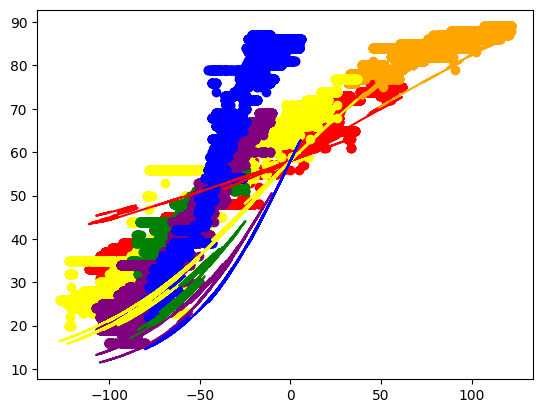

In [123]:
import matplotlib.pyplot as plt 

ten_thirty = int(datetime.datetime.strptime(f"{date} 10:30", "%Y-%m-%d %H:%M").timestamp())
eleven_thirty = int(datetime.datetime.strptime(f"{date} 11:30", "%Y-%m-%d %H:%M").timestamp())
twleve_thirty = int(datetime.datetime.strptime(f"{date} 12:30", "%Y-%m-%d %H:%M").timestamp())
one_thirty = int(datetime.datetime.strptime(f"{date} 13:30", "%Y-%m-%d %H:%M").timestamp())
two_thirty = int(datetime.datetime.strptime(f"{date} 14:30", "%Y-%m-%d %H:%M").timestamp())
three_thirty = int(datetime.datetime.strptime(f"{date} 15:30", "%Y-%m-%d %H:%M").timestamp())
four = int(datetime.datetime.strptime(f"{date} 16:00", "%Y-%m-%d %H:%M").timestamp())

ten = cdf[(cdf.ts >= ten_thirty) & (cdf.ts <= eleven_thirty)]
ten = get_cdf_with_params(ten, params)
plt.scatter(ten.spy_diff_from_threshold, ten.yes_bid_price, color ='red')
plt.plot(ten.spy_diff_from_threshold, 100*ten.sigmoid, color ='red')
eleven = cdf[(cdf.ts >= eleven_thirty) & (cdf.ts <= twleve_thirty)]
eleven = get_cdf_with_params(eleven, params)
plt.scatter(eleven.spy_diff_from_threshold, eleven.yes_bid_price, color ='orange')
plt.plot(eleven.spy_diff_from_threshold, 100*eleven.sigmoid, color ='orange')
twelve = cdf[(cdf.ts >= twleve_thirty) & (cdf.ts <= one_thirty)]
twelve = get_cdf_with_params(twelve, params)
plt.scatter(twelve.spy_diff_from_threshold, twelve.yes_bid_price, color ='yellow')
plt.plot(twelve.spy_diff_from_threshold, 100*twelve.sigmoid, color = "yellow")
one = cdf[(cdf.ts >= one_thirty) & (cdf.ts <= two_thirty)]
one = get_cdf_with_params(one, params)
plt.scatter(one.spy_diff_from_threshold, one.yes_bid_price, color ='green')
plt.plot(one.spy_diff_from_threshold, 100*one.sigmoid, color = "green")
two = cdf[(cdf.ts >= two_thirty) & (cdf.ts <= three_thirty)]
two = get_cdf_with_params(two, params)
plt.scatter(two.spy_diff_from_threshold, two.yes_bid_price, color ='purple')
plt.plot(two.spy_diff_from_threshold, 100*two.sigmoid, color = "purple")
three = cdf[(cdf.ts >= three_thirty) & (cdf.ts <= four)]
three = get_cdf_with_params(three, params)
plt.scatter(three.spy_diff_from_threshold, three.yes_bid_price, color ='blue')
plt.plot(three.spy_diff_from_threshold, 100*three.sigmoid, color = "blue")

# Graph sigmoid curves 
# x =[i for i in range(-200, 200)]
# plt.plot(x, [100*sigmoid(t, 0.005) for t in x], color = "black")
# plt.plot(x, [100*sigmoid(t, 0.01) for t in x], color = "black")
# plt.plot(x, [100*sigmoid(t, 0.02) for t in x], color = "black")
# plt.plot(x, [100*sigmoid(t, 0.025) for t in x], color = "black")

plt.show()

In [103]:
cdf

,ts,spy_price,yes_bid_price,yes_bid_qty,yes_ask_price,yes_ask_qty,spy_diff_from_threshold,spy_price_expanding_std_dev,w,sigmoid
6618,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,NaN,0.006487,0.613139
6619,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,0.000000,0.006487,0.613139
6620,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,0.000000,0.006487,0.613139
6621,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,0.000000,0.006487,0.613139
6622,1.701355e+09,45550.0,61.0,125.0,65.0,50.0,44.2,0.000000,0.006487,0.613139
...,...,...,...,...,...,...,...,...,...,...
223918,1.701378e+09,45631.0,81.0,125.0,95.0,100.0,125.2,76.562518,0.016084,0.924168
223919,1.701378e+09,45631.0,81.0,125.0,95.0,100.0,125.2,76.563068,0.016084,0.924168
223920,1.701378e+09,45631.0,81.0,125.0,95.0,100.0,125.2,76.563617,0.016084,0.924168
223921,1.701378e+09,45631.0,81.0,125.0,95.0,100.0,125.2,76.564167,0.016084,0.924169


In [95]:
from scipy.optimize import minimize

def minimize_bids(input_cdf):
    def f(x):
        global cdf
        cdf = get_cdf_with_params(input_cdf, x)
        # Adjust below for bids (yes_ask_price)
        return abs((100*cdf.sigmoid) - cdf.yes_bid_price).sum()
    return f 
def callback(x, f=None, accepted= None):
    print(f"Iteration {callback.iteration}: x = {x}, f(x) = {f}, accepted = {accepted}")
    callback.iteration += 1
callback.iteration = 0
# Nelder-Mean method
result = minimize(
        minimize_bids(cdf),
        [0, -6.25e-07 , 0.025],
        method="Nelder-Mead",
        callback=callback

    )

Iteration 0: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 1: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 2: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 3: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 4: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 5: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 6: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 7: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 8: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 9: x = [ 4.19435017e-02 -4.10109665e-07  1.60835979e-02], f(x) = None, accepted = None
Iteration 10: x = [ 4.19435017

In [89]:
result.x

array([ 4.19435017e-02, -4.10109665e-07,  1.60835979e-02])

In [91]:
minimize_bids(cdf)([1.04353536e-01, 2.08711009e+03])

921509.6590224156